# Analysis of CL model run

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

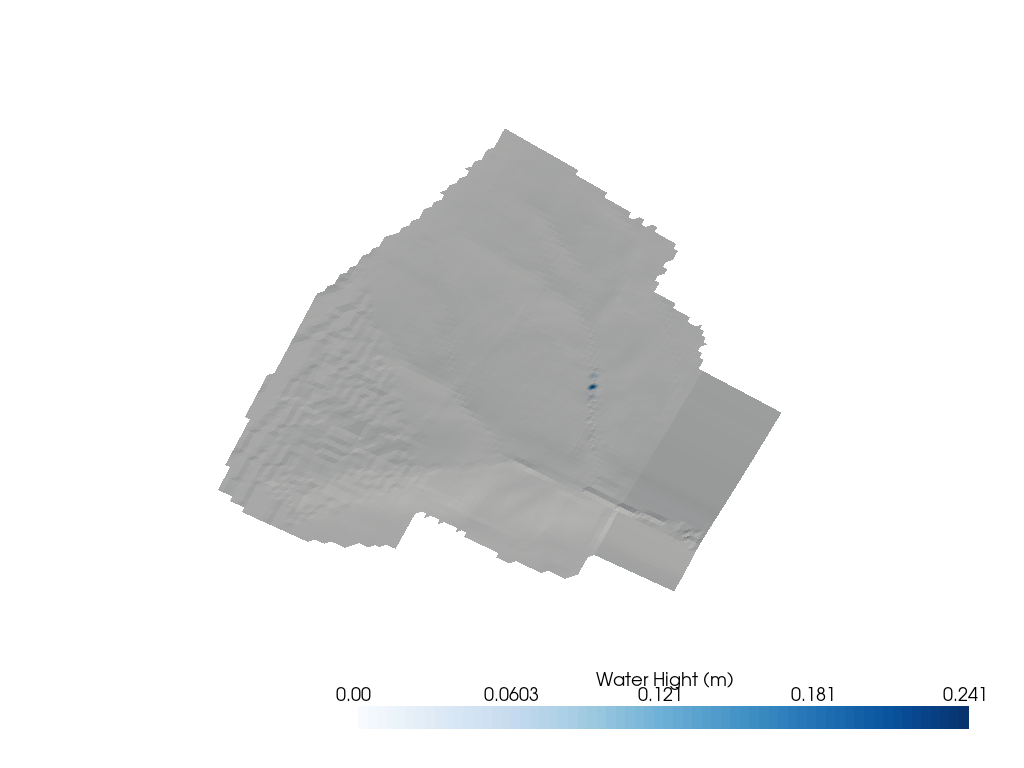

[(1252.3113078544443, 57.667618592004146, 2771.2269290128343),
 (-998.7813915579818, 1194.0290590469476, -5477.0177030983605),
 (0.4415550130087225, -0.8646424633461258, -0.23963009215374143)]

In [2]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/results/Elevations129600.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)

# the matrix gets fliped when I read it so I add a 180° rotation
z = np.flip(np.flip(data_array, 1), 0)

x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/results/WaterDepths129600.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)

# the matrix gets fliped when I read it so I add a 180° rotation
zwater = np.flip(np.flip(data_array, 1), 0)

water = pv.StructuredGrid(x, y, zwater)
d = np.zeros_like(water.points)
d[:, 1] = water.points[:, 2]

# To modify cpos (position of camera) change notebook=True to False and manipulate the plot
# this will then return the cpos and you can edit this parameter below and re-run the cell
cpos = [(1252.3113078544443, 57.667618592004146, 2771.2269290128343),
        (-998.7813915579818, 1194.0290590469476, -5477.0177030983605),
        (0.4415550130087225, -0.8646424633461258, -0.23963009215374143)]

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1], cmap='Blues')  #, clim=[0,2])
p.camera_position = cpos
p.add_scalar_bar(title='Water Hight (m)')
p.show(screenshot='CL_water.png')

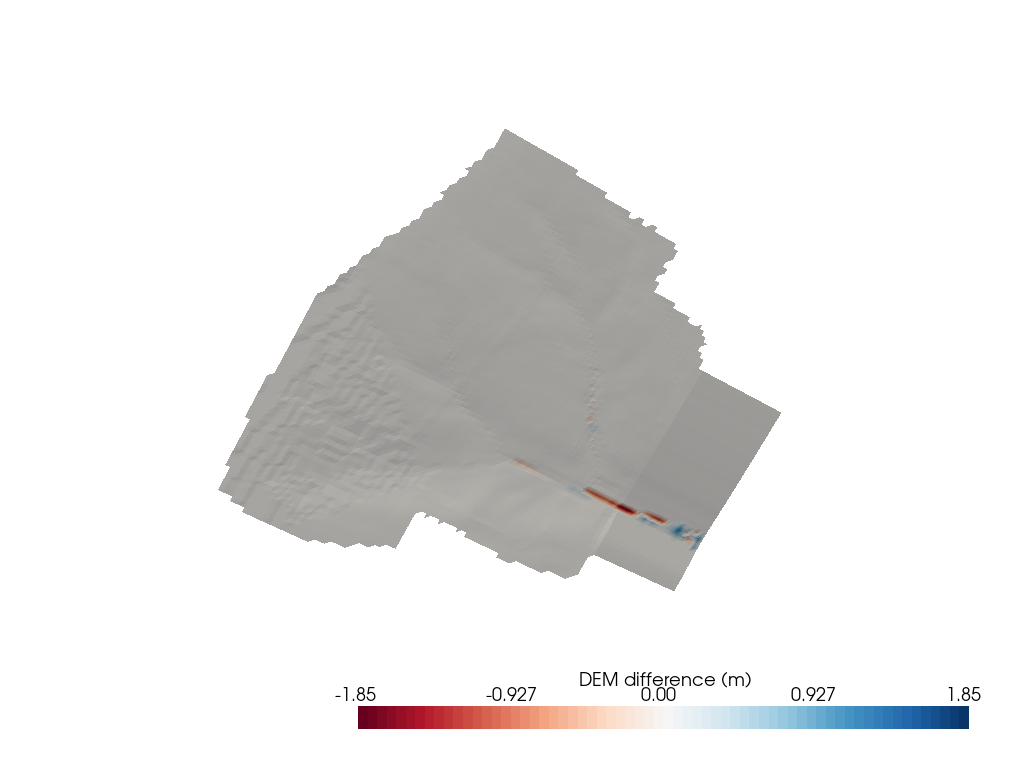

[(1252.3113078544443, 57.667618592004146, 2771.2269290128343),
 (-998.7813915579818, 1194.0290590469476, -5477.0177030983605),
 (0.4415550130087225, -0.8646424633461258, -0.23963009215374143)]

In [3]:
ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/results/Elevations129600.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)

# the matrix gets fliped when I read it (180° rotation)
z = np.flip(np.flip(data_array, 1), 0)

x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/pommeroye/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)

# the matrix gets fliped when I read it (180° rotation)
zstart = np.flip(np.flip(data_array, 1), 0)

z0 = pv.StructuredGrid(x, y,zstart)
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='CL_DEMdiff.png')

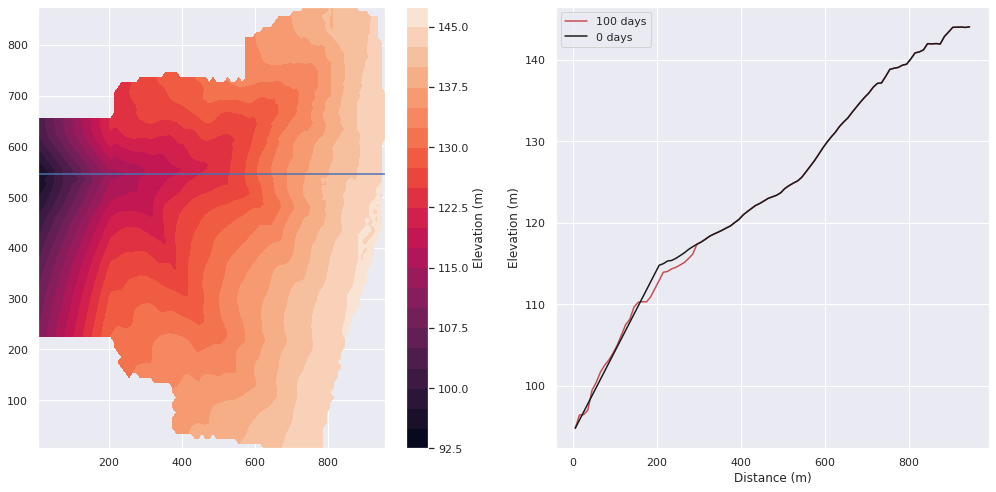

In [4]:
cut = 54

sns.set(rc={'figure.figsize':(14, 7)})
plt.figure()
plt.subplot(1,2,1)
plt.contourf(x, y, z, 20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.plot(x[cut,:], y[cut,:])
plt.subplot(1,2,2)
plt.plot(x[cut,:], z[cut,:], 'r')
plt.plot(x[cut,:], zstart[cut,:], 'k')
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.legend(['100 days','0 days'])
plt.tight_layout()
plt.savefig('CL_profile.jpg')
plt.show()

<Figure size 1080x1080 with 0 Axes>

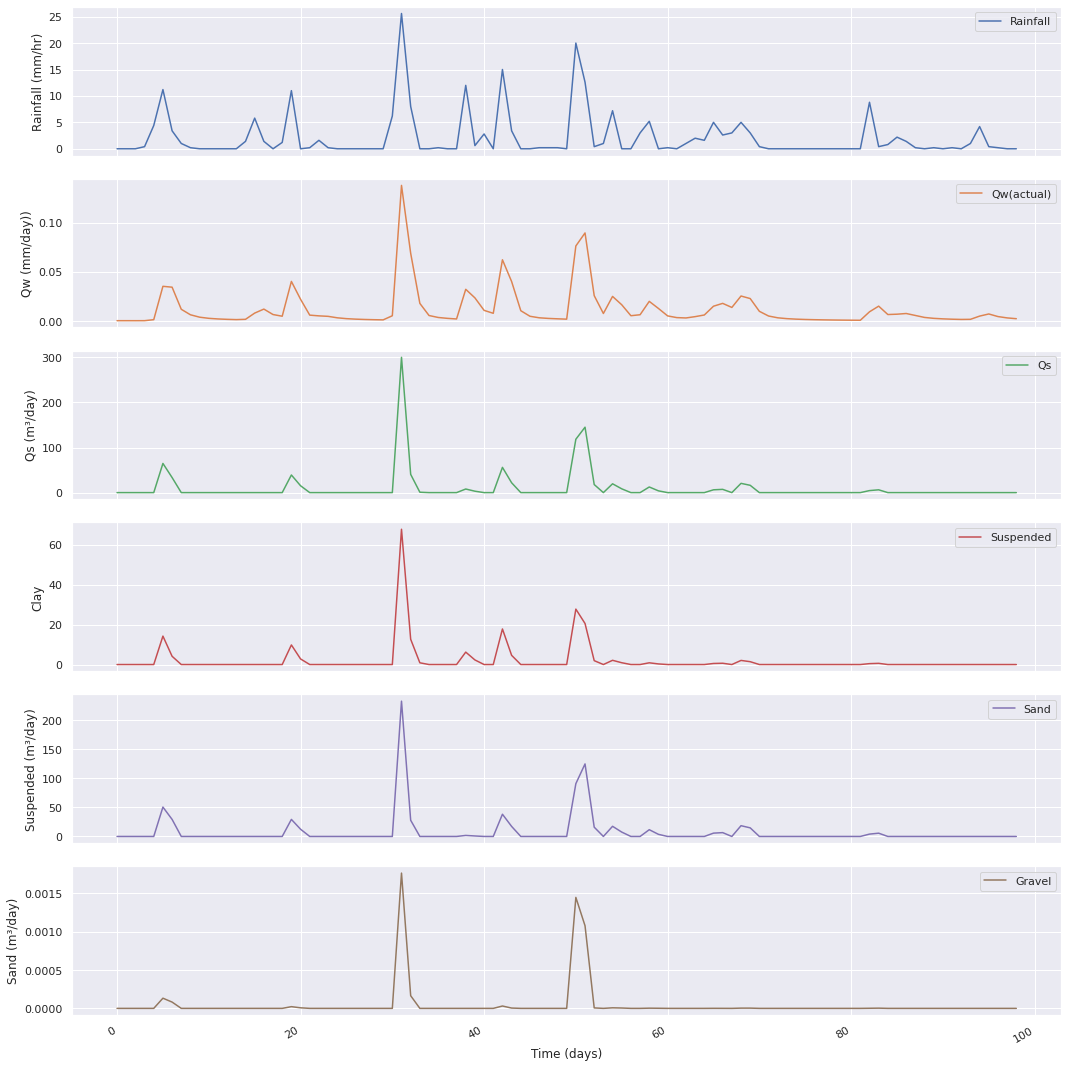

In [5]:
file = '/work/armitagj/runs/caesar-explore/pommeroye/results/sedoutput.dat'
seds_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/pommeroye/input_data/rainfall_per_day.txt'
rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
seds_all = pd.concat([seds_, rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
cols_label = ['Rainfall (mm/hr)', 'Qw (mm/day))', 'Qs (m³/day)', 'Clay', 'Suspended (m³/day)', 'Sand (m³/day)', 'Gravel (m³/day)']
axes = seds_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time (days)')
plt.tight_layout()
plt.savefig('timeseries.jpg')
plt.show()

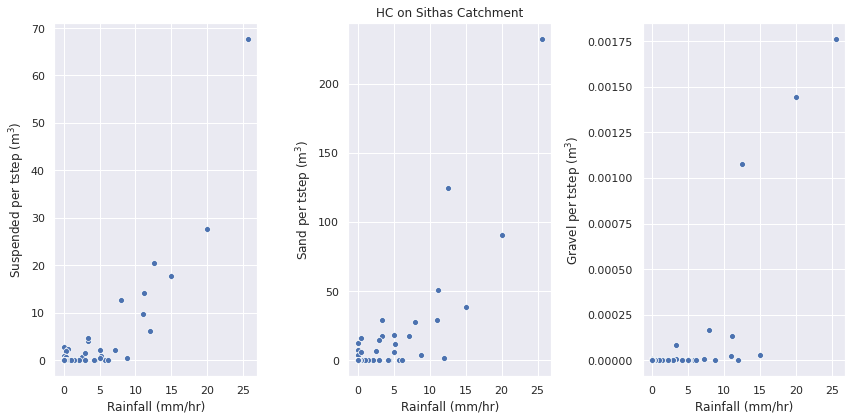

In [6]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)

g = sns.scatterplot(seds_all['Rainfall'], seds_all['Suspended'], ax=ax1)

model = sm.OLS(seds_all['Suspended'],sm.add_constant(seds_all['Rainfall']),missing='drop').fit()
xx = np.linspace(seds_all['Rainfall'].min(), seds_all['Rainfall'].max(), 2)
yy = model.params[0] + xx*model.params[1]
#plt.plot(xx, yy, 'k')
#plt.text(0.05, np.max(sithas_all['Suspended']), 'R² = ' + str(np.round(model.rsquared,3)))
#plt.text(0.05, np.max(sithas_all['Suspended']), 'R² = ' + str(sithas_all['Rainfall'].max()))

g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(seds_all['Rainfall'], seds_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(seds_all['Rainfall'], seds_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('yield_precip.jpg')
plt.show()

In [7]:
windows = [5, 10, 20]
for window in windows:
    
    seds_all['Rainfall Rolling Std. ' + str(window)] = seds_all['Rainfall'].rolling(window).std().values
    seds_all['Rainfall Rolling Mean. ' + str(window)] = seds_all['Rainfall'].rolling(window).mean().values
    seds_all['Rainfall Rolling Median. ' + str(window)] = seds_all['Rainfall'].rolling(window).median().values
    
    seds_all['Suspended Rolling Std. ' + str(window)] = seds_all['Suspended'].rolling(window).std().values
    seds_all['Suspended Rolling Mean. ' + str(window)] = seds_all['Suspended'].rolling(window).mean().values
    seds_all['Suspended Rolling Median. ' + str(window)] = seds_all['Suspended'].rolling(window).median().values
    
    seds_all['Sand Rolling Std. ' + str(window)] = seds_all['Sand'].rolling(window).std().values
    seds_all['Sand Rolling Mean. ' + str(window)] = seds_all['Sand'].rolling(window).mean().values
    seds_all['Sand Rolling Median. ' + str(window)] = seds_all['Sand'].rolling(window).median().values
    
    seds_all['Gravel Rolling Std. ' + str(window)] = seds_all['Gravel'].rolling(window).std().values
    seds_all['Gravel Rolling Mean. ' + str(window)] = seds_all['Gravel'].rolling(window).mean().values
    seds_all['Gravel Rolling Median. ' + str(window)] = seds_all['Gravel'].rolling(window).median().values

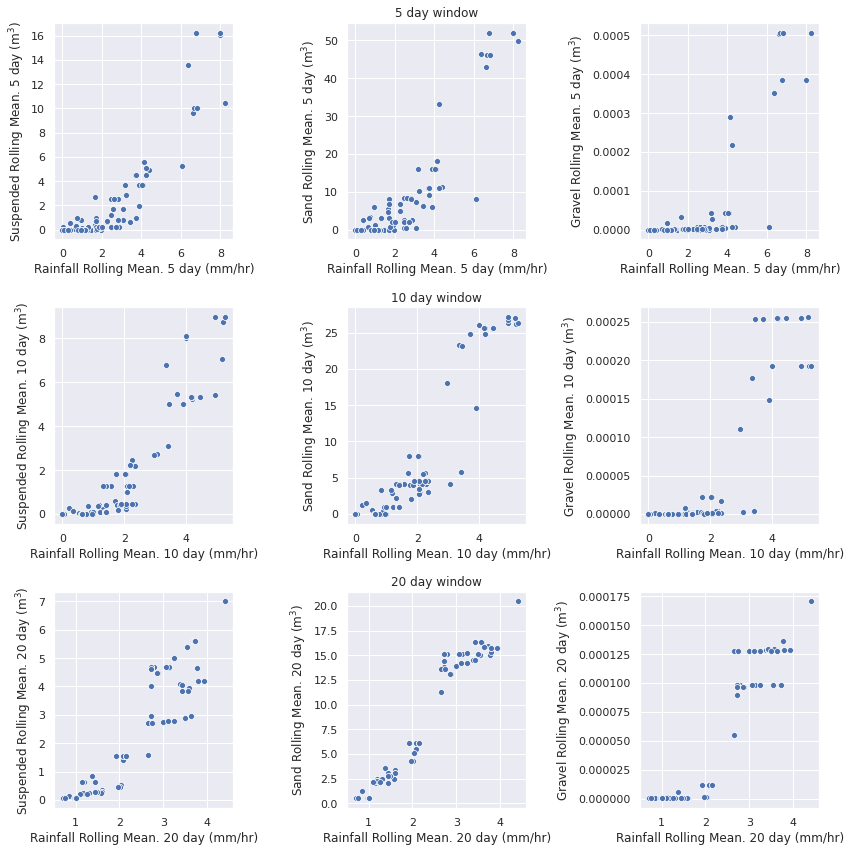

In [8]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    
    model = sm.OLS(seds_all['Suspended Rolling Mean. ' + str(window)],sm.add_constant(seds_all['Rainfall Rolling Mean. ' + str(window)],),missing='drop').fit()
    xx = np.linspace(np.min(seds_all['Rainfall Rolling Mean. ' + str(window)]), np.max(seds_all['Rainfall Rolling Mean. ' + str(window)]), 2)
    yy = model.params[0] + xx*model.params[1]
    # plt.plot(xx, yy, 'k')
    # plt.text(0.05, np.max(seds_all['Suspended Rolling Mean. ' + str(window)]), 'R² = ' + str(np.round(model.rsquared,3)))
    
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(seds_all['Rainfall Rolling Mean. ' + str(window)],
                        seds_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.savefig('yield_precip_rollmean.jpg')
plt.show()

<Figure size 1080x1080 with 0 Axes>

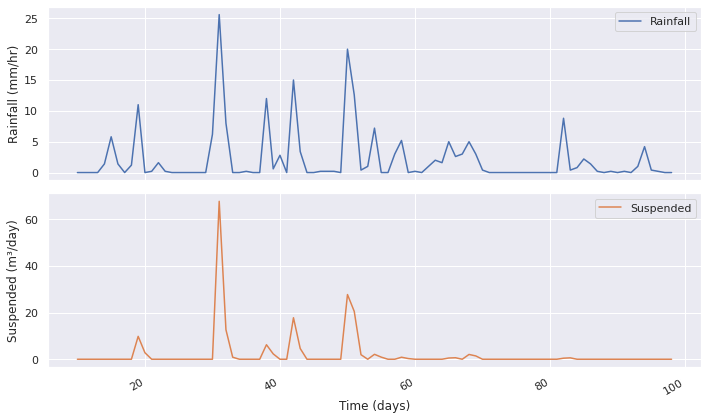

In [9]:
plt.figure()
sns.set(rc={'figure.figsize':(10,6)})
cols_plot = ['Rainfall', 'Suspended']
cols_label = ['Rainfall (mm/hr)', 'Suspended (m³/day)']
axes = seds_all[cols_plot][10:].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time (days)')
plt.tight_layout()
plt.savefig('sub_tseries.png')
plt.show()